In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Dynamic memory growth enabled")
    except RuntimeError as e:
        print(e)

train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

img_size = 224

Dynamic memory growth enabled


In [13]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [14]:
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,
    target_size = (img_size,img_size),
    color_mode = "rgb",
    class_mode = "categorical",
    subset = "training"
)
validation_generator = validation_datagen.flow_from_directory(
    directory = test_dir,
    target_size = (img_size,img_size),
    color_mode = "rgb",
    class_mode = "categorical",
    subset = "validation"
)

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


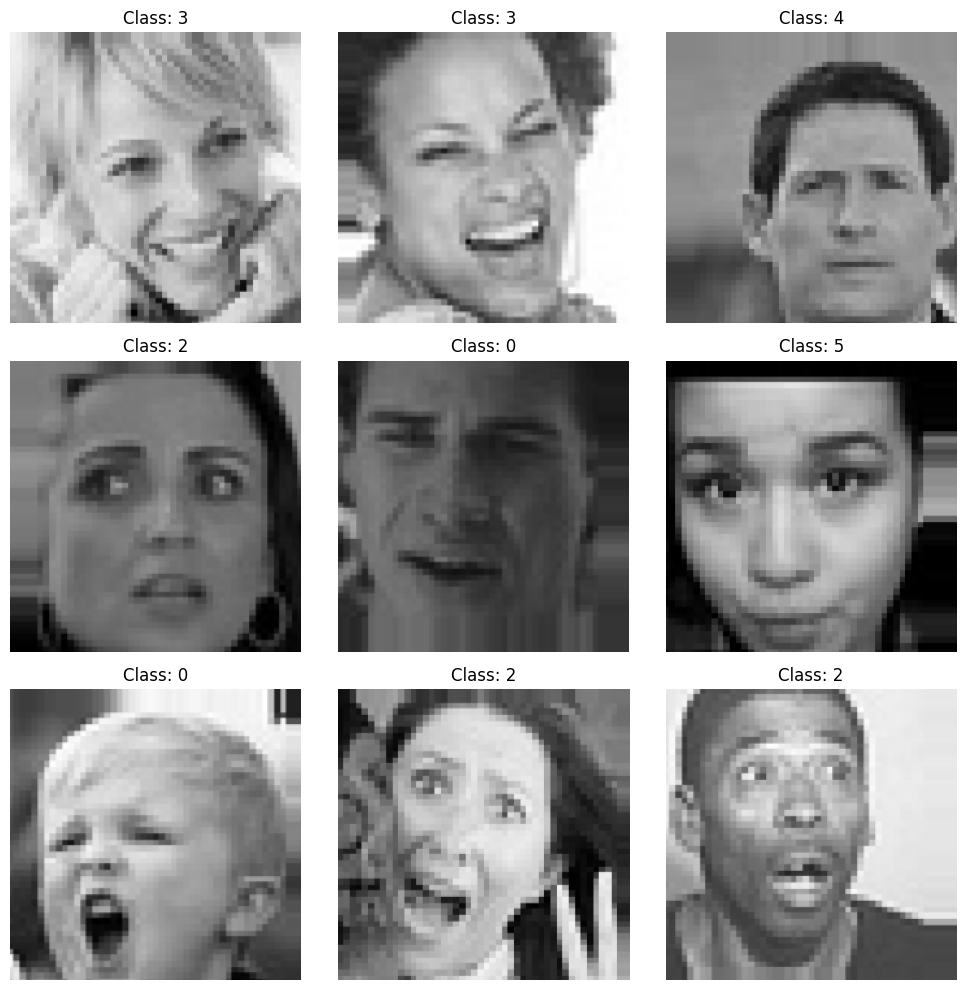

In [15]:
import matplotlib.pyplot as plt

images, labels = next(train_generator)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel() 

for i in range(9):  # Display the first 9 images
    axes[i].imshow(images[i].squeeze(), cmap='gray') 
    axes[i].set_title(f"Class: {labels[i].argmax()}")  
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [16]:
print(f"Shape of images in batch: {images[0].shape}")

Shape of images in batch: (224, 224, 3)


#### Transfer Learning

In [17]:
from tensorflow import keras
from tensorflow.keras import layers

model = tf.keras.applications.MobileNetV2()

In [18]:
base_input = model.layers[1].input  
base_output = model.layers[-2].output
base_input

<KerasTensor shape=(None, 224, 224, 3), dtype=float16, sparse=None, name=keras_tensor_161>

In [19]:
final_output = layers.Dense(128)(base_output) # new layer added after the output of the global pooling layer
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7, activation='softmax', dtype='float32')(final_output)  # Force output to float32


In [20]:
final_output

<KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_321>

In [21]:
new_model = keras.Model(inputs = base_input, outputs = final_output)
epochs = 30

In [22]:
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers import Adam

mixed_precision.set_global_policy('mixed_float16')

optimizer = Adam(learning_rate=0.001)
new_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
new_model.fit(x=train_generator, epochs=epochs, validation_data=validation_generator)

Epoch 1/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 411s 484ms/step - accuracy: 0.4338 - loss: 1.4568 - val_accuracy: 0.2807 - val_loss: 2.6885
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 246s 339ms/step - accuracy: 0.5729 - loss: 1.1388 - val_accuracy: 0.1746 - val_loss: 4.5074
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 241s 332ms/step - accuracy: 0.6000 - loss: 1.0701 - val_accuracy: 0.2954 - val_loss: 3.6447
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 263s 334ms/step - accuracy: 0.6195 - loss: 1.0198 - val_accuracy: 0.3918 - val_loss: 2.6467
Epoch 5/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 239s 330ms/step - accuracy: 0.6347 - loss: 0.9771 - val_accuracy: 0.4895 - val_loss: 1.9741
Epoch 6/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 241s 332ms/step - accuracy: 0.6425 - loss: 0.9517 - val_accuracy: 0.4756 - val_loss: 1.8287
Epoch 7/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 242s 334ms/step - accuracy: 0.6507 - loss: 0.9295 - val_accuracy: 0.4784 - val_loss: 1.9652
Epoch 8/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 241s 332ms/step - accuracy: 0.6669 -

In [23]:
# Save the trained model
new_model.save('emotion_recognition_model.h5')
print("Model saved as emotion_recognition_model.h5")

Model saved as emotion_recognition_model.h5
